In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# from keras.preprocessing.image import load_img,img_to_array
# from keras.keras.preprocessing.image import ImageDataGenerator
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

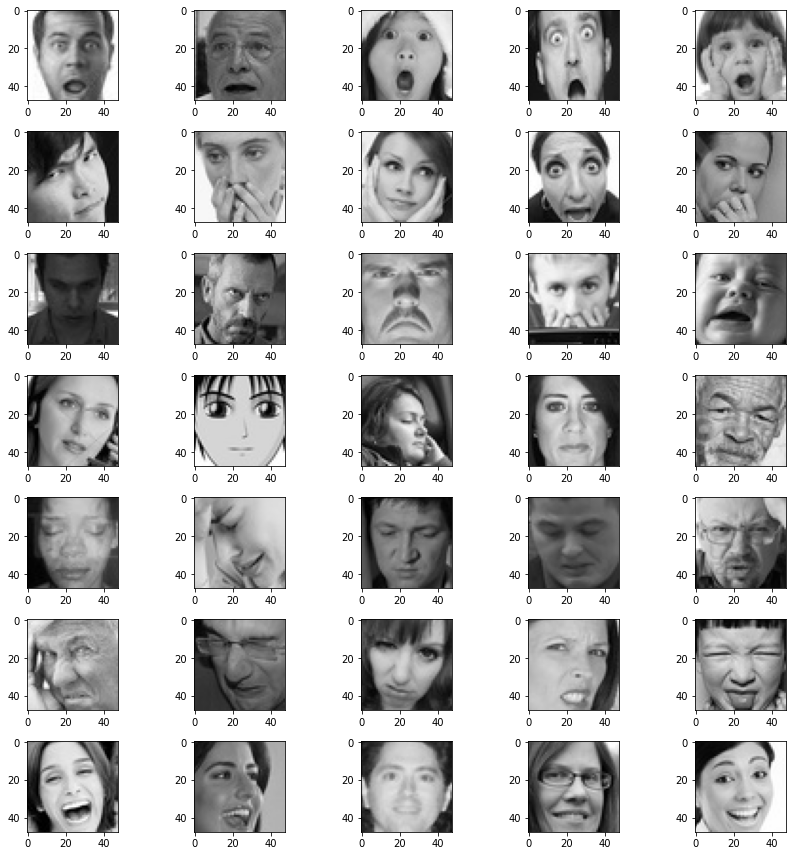

In [3]:
from keras.preprocessing.image import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
pic_size=48
path="/kaggle/input/face-expression-recognition-dataset/images/"
plt.figure(figsize=(12,12))
pos=0
for expression in os.listdir(path+"train/"):
    for i in range(1,6):
        pos=pos+1
        plt.subplot(7,5,pos)
        img=load_img(path+"train/"+expression+"/"+os.listdir(path+"train/"+expression)[i],target_size=(pic_size,pic_size))
        plt.imshow(img,cmap='gray')
plt.tight_layout()
plt.show()

In [4]:
batch_size=128
train_data=ImageDataGenerator(rescale=1.0/255.0,width_shift_range=0.1,height_shift_range=0.1,rotation_range=20,horizontal_flip=True)
validation_data=ImageDataGenerator(rescale=1.0/255.0)
train_gen=train_data.flow_from_directory(path+"train",target_size=(56,56),color_mode="grayscale",class_mode="categorical",shuffle=True)
validation_gen=validation_data.flow_from_directory(path+"validation",target_size=(56,56),color_mode="grayscale",class_mode="categorical",shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [5]:
from keras.layers import Dense,Input,Conv2D,Dropout,GlobalAveragePooling2D,Flatten,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
num_classes=7
model=Sequential()

# 1st conv layer
model.add(Conv2D(64,(3,3),padding="same",input_shape=(56,56,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# 2nd conv layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd conv layer
model.add(Conv2D(512,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
                       
# 4th conv layer
model.add(Conv2D(512,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Flatten
model.add(Flatten())
          
#fully connected
#1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))
          
#2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))
          
model.add(Dense(num_classes,activation="softmax"))
          
print(model.summary())
opt=Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       5

In [ ]:
# number of epochs to train the NN
epochs = 50

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_gen,
                                steps_per_epoch=train_gen.n//train_gen.batch_size,
                                epochs=epochs,
                                validation_data = validation_gen,
                                validation_steps = validation_gen.n//validation_gen.batch_size,
                                callbacks=callbacks_list
                                )